In [1]:
import geopandas as gpd
import pandas as pd
from shapely.geometry.polygon import LinearRing
from shapely.geometry import box, Polygon
import time
import shapely.wkt
import matplotlib.pyplot as plt

In [2]:
# Load neccessary datasets
vierkant = gpd.read_file("../Data/NLvierkant/NL_vierkant100m.shp")
df = pd.read_csv("woonplaats_grenzen.csv" , sep = ";")

In [3]:
for i in df.woonplaats.unique():
    print(i)

Hoogerheide
Huijbergen
Ossendrecht
Putte
Woensdrecht
Gouda
Waalre
Middelburg
Arnemuiden
Nieuw- en Sint Joosland
Etten-Leur
Huizen
Weesp
Soest
Soesterberg
Vlaardingen
Nieuwerkerk aan den IJssel
Foxhol
Hoogezand
Kiel-Windeweer
Kropswolde
Sappemeer
Waterhuizen
Westerbroek
Amsterdam
Amsterdam Zuidoost
America
Broekhuizen
Broekhuizenvorst
Griendtsveen
Grubbenvorst
Hegelsom
Horst
Lottum
Melderslo
Meterik
Hilversum
Eemnes
Daarle
Daarlerveen
Haarle
Hellendoorn
Nijverdal
Tilburg
Berkel-Enschot
Udenhout
Staphorst
Rouveen
IJhorst
Punthorst
Amstelveen
Lelystad
Naarden
Andijk
Barneveld
Voorthuizen
Kootwijkerbroek
Garderen
Terschuur
Stroe
Zwartebroek
De Glind
Kootwijk
Achterveld
Bladel
Hapert
Hoogeloon
Casteren
Netersel
Maassluis
Groningen
Woerden
Harmelen
Kamerik
Zegveld
Zeewolde
Oost-Souburg
Ritthem
Vlissingen
Aarlanderveen
Alphen aan den Rijn
Zwammerdam
Meppel
Nijeveen
Rogat
De Schiphorst
Wierden
Enter
Hoge Hexel
Notter
Zuna
Baarn
Lage Vuursche
Dodewaard
Echteld
Kesteren
Ochten
Opheusden
IJzendoo

Ter Heijde
Wateringen
Bodegraven
Nieuwerbrug aan den Rijn
Nieuwkoop
Noorden
Woerdense Verlaat
Nieuwveen
Zevenhoven
Vrouwenakker
Ter Aar
Brouwershaven
Bruinisse
Burgh-Haamstede
Dreischor
Ellemeet
Kerkwerve
Nieuwerkerk
Noordgouwe
Noordwelle
Oosterland
Ouwerkerk
Renesse
Scharendijke
Serooskerke
Sirjansland
Zierikzee
Zonnemaire
Baars
Basse
Belt-Schutsloot
Blankenham
Blokzijl
De Bult
De Pol
Eesveen
Giethoorn
IJsselham
Kalenberg
Kallenkote
Kuinre
Marijenkampen
Nederland
Oldemarkt
Onna
Ossenzijl
Paasloo
Scheerwolde
Sint Jansklooster
Steenwijk
Steenwijkerwold
Tuk
Vollenhove
Wanneperveen
Wetering
Willemsoord
Witte Paarden
Zuidveen
Bitgum
Bitgummole
Berltsum
Blessum
Boksum
Deinum
Ingelum
Dronryp
Marsum
Menaam
Skingen
Slappeterp
Wier
Beverwijk
Wijk aan Zee
De Cocksdorp
De Koog
De Waal
Den Burg
Den Hoorn Texel
Den Hoorn
Oosterend Nh
Oudeschild
Oegstgeest
Someren
Lierop
Geffen
Nuland
Vinkel
Weurt
Beuningen Gld
Ewijk
Winssen
Enkhuizen
Uitgeest
Schagerbrug
Callantsoog
't Zand
Sint Maartensbrug
Sint M

In [3]:
class city_grid():
    def __init__(self, city_borders, grid, city):
        
        # Select only the city_borders of wanted city and transform geometry (string) to geometry object
        self.city_borders = city_borders[city_borders.woonplaats.str.contains(city)]
        self.city_borders.geometry = self.city_borders.geometry.apply(shapely.wkt.loads)
        
        self.grid = grid
        self.city = city
        self.union = LinearRing()
        self.df = gpd.GeoDataFrame()
    
    def border_fix(self, name):
        self.city_borders =  self.city_borders[~self.city_borders.woonplaats.str.contains(name)]
        
    
    def print_borders(self):
        print(self.city_borders)
    def create_union(self):
        for _, i in self.city_borders.iterrows():
            if not i.geometry.is_empty:
                x, y = i.geometry.xy
                self.union = self.union.union(i.geometry)
                plt.plot(x, y)
        plt.show()
        
    def create_grid(self):

        def create_box(bounds, distance):
            xmin, ymin, xmax, ymax = bounds
            xmin -= distance
            ymin -= distance
            xmax += distance
            ymax += distance

            return xmin, ymin, xmax, ymax


        boundbox = box(*create_box(self.union.bounds, 100))
        
        
        tot = len(self.grid)
        for i, v in self.grid.iterrows():
            print("{0:.1f}%".format((i / tot) * 100), end = "\r")
            if boundbox.contains(v.geometry):
                self.df = self.df.append(v)
        
    def save_grid(self):
        self.df.to_csv(self.city + "_grid.csv")

C:\Users\Gebruiker\anaconda3\lib\site-packages\pandas\core\generic.py:5516: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


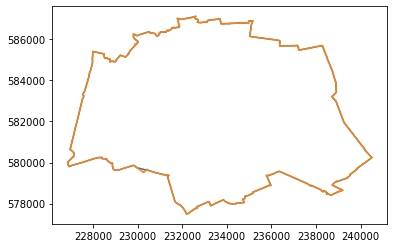

In [4]:
cg = city_grid( df, vierkant, "Groningen")
cg.create_union()


In [5]:
cg.create_grid()

In [6]:
cg.save_grid()

In [22]:
cg.city

'Tilburg'

In [17]:
x, y = cg.geometry.xy
plt.plot(x, y)
xbox, ybox = box(*create_box(cg.geometry.bounds, 1000)).exterior.xy

plt.plot(xbox, ybox)

AttributeError: 'city_grid' object has no attribute 'geometry'